Epoch 1/10 Train Loss: 1.9054 Val Loss: 1.8796 Train Acc: 0.1937 Val Acc: 0.1945
Epoch 2/10 Train Loss: 1.8697 Val Loss: 1.8620 Train Acc: 0.1945 Val Acc: 0.1945
Epoch 3/10 Train Loss: 1.8588 Val Loss: 1.8556 Train Acc: 0.1944 Val Acc: 0.1945
Epoch 4/10 Train Loss: 1.8552 Val Loss: 1.8532 Train Acc: 0.1942 Val Acc: 0.1945
Epoch 5/10 Train Loss: 1.8527 Val Loss: 1.8511 Train Acc: 0.1933 Val Acc: 0.1945
Epoch 6/10 Train Loss: 1.8509 Val Loss: 1.8465 Train Acc: 0.1928 Val Acc: 0.1945
Epoch 7/10 Train Loss: 1.8469 Val Loss: 1.8399 Train Acc: 0.1965 Val Acc: 0.2010
Epoch 8/10 Train Loss: 1.8392 Val Loss: 1.8331 Train Acc: 0.2035 Val Acc: 0.2097
Epoch 9/10 Train Loss: 1.8335 Val Loss: 1.8286 Train Acc: 0.2037 Val Acc: 0.2149
Epoch 10/10 Train Loss: 1.8315 Val Loss: 1.8289 Train Acc: 0.2064 Val Acc: 0.2087


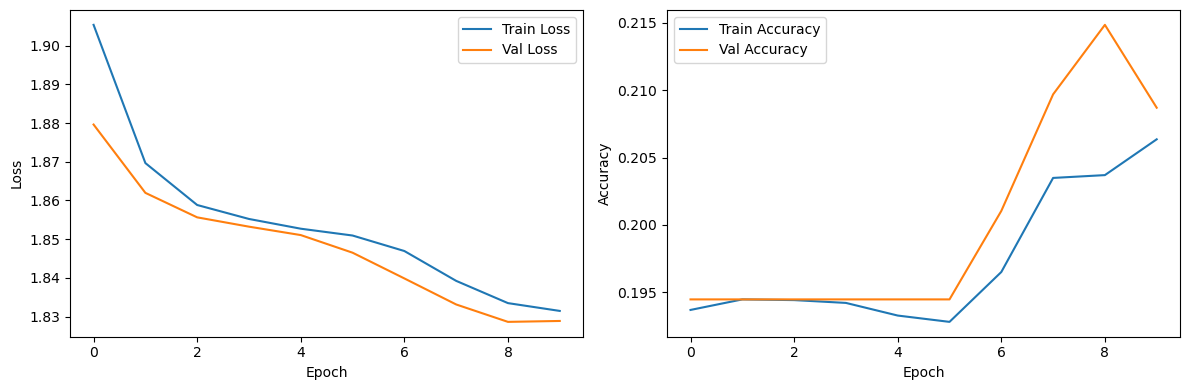

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the VGGNet model with reduced complexity
class VGGNet(nn.Module):
    def __init__(self, num_classes=7):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder('images_reduced/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
model = VGGNet(num_classes=7).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = correct_train / total_train

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_accuracy = correct_val / total_val

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} "
          f"Train Acc: {train_accuracy:.4f} Val Acc: {val_accuracy:.4f}")

# Save the training history
np.save('vggnet_history.npy', {
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_acc': train_acc_history,
    'val_acc': val_acc_history
})


# Save the trained model
torch.save(model.state_dict(), 'models/VGGNet_Model_50epcohs.pth')

# Plot loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


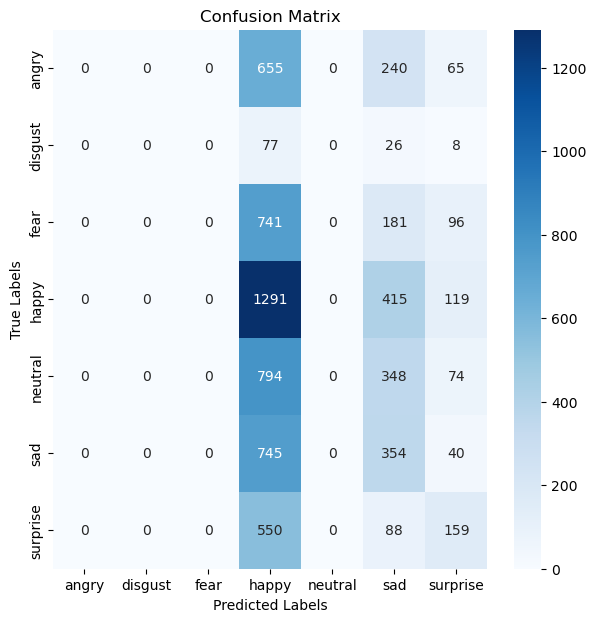

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the validation dataset
val_dataset = ImageFolder('images/validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
 

# Evaluate on the validation set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_dataset.classes

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()